# Predicting Popular Music - Spotify & Machine Learning


## Phase 2 - Feature Selection, Model Fitting and Evaluation

#### Authors:
Alexander Hudson <br> 
Student 2 <br> 
Student 3

## Table of Contents

1. [Introduction](#IN) <br>
    1.1. [Report Overview](#OR) <br>
    1.2. [Overview of Methodology](#OM) <br>
    1.3. [Reading in the Spotify Dataset](#RD) <br>
    1.4. [Splitting the Data into Training and Testing](#TT)

2. [Predictive Modelling](#PM) <br>
    2.1. [Feature Selection](#FS) <br>
    * 2.1.1 [F-Score](#FSC) <br>
    * 2.1.2 [Mutual Information](#MI) <br>
    * 2.1.3 [Random Forest Indicator](#RFI) <br>

    2.2. [Model Fitting and Tuning](#FT) <br>
    * 2.2.1 [K Nearest Neighbours](#NN1) <br>
    * 2.2.2 [Decision Tree](#DT1) <br>
    * 2.2.3 [Random Forest](#RF1) <br>
    * 2.2.4 [Naive Bayes](#EB1) <br>
    * 2.2.5 [Support-Vector Machine](#SV1) <br>

    2.3. [Model Comparison and Evaluation](#MC) <br>
    * 2.3.1 [K Nearest Neighbours](#NN2) <br>
    * 2.3.2 [Decision Tree](#DT2) <br>
    * 2.3.3 [Random Forest](#RF2) <br>
    * 2.3.4 [Naive Bayes](#EB2) <br>
    * 2.3.5 [Support-Vector Machine](#SV2) <br>
    * 2.3.6 [Performance Comparison](#PC) <br>
    * 2.3.7 [Best Model](#BM)

3. [Critiques and Limitations](#CL)

4. [Summary](#SM)<br>
    4.1. [Project Summary](#PS) <br>
    4.2. [Summary of Findings](#SF) <br>

5. [Conclusions](#CO)
6. [References](#REF)


# <a id = "IN">Introduction</a>

## <a id = "OR">Report Overview</a>

In Phase 1 of the project, the Spotify dataset was preprocessed, one-hot-encoded, and robust scaling was applied for all non-encoded features. Phase 2 of the project aims to predict, with the provided descriptive features, if the songs were in the Billboard's Weekly Top 100 charts from 2010 to 2019. For this, the dataset will be run through the following Machine-Learning classifier algorithms:

* K Nearest Neighbors (KNN),
* Decision Tree (DT),
* Random Forest (RF),
* Naive Bayes (NB), and
* Support-Vector Machine (SVM).

The best possible model will be decided through evaluations that rank how well the target feature (whether or not a given song appears on Billboard's Weekly Top 100 charts) is predicted by the descriptive features.

## <a id = "OM">Overview of Methodology</a>

The dataset will go through a process of feature selection due to the number of descriptive features in the encoded dataset. The features will be judged through F-scores, Mutual Information scores, and random forest Indicator scores. The dataset will then be narrowed down to the most appropriate six features as decided by the different scores. The models produced from the selected features from each score will then cross-validated and compared to a model using the original dataset, which includes all descriptive features.

Once the best features have been selected, the dataset will be fitted to each model. To find the best parameters for each model, grid searches will be run with Area Under the ROC Curve scoring (AUC). To evaluate each model, accuracy, precision, recall and reciever operator characteristic (ROC) curves will be used. Finally, paired sample t-tests will be conducted to ensure that the most appropriate model is a statistically improvement from the other models.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import sklearn.metrics as metrics
from sklearn import feature_selection as fs
from scipy import stats
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

## <a id = 'RD'>Reading in the Spotify Dataset</a>

In [2]:
#Reading in the dataset
spotify = pd.read_csv('C:/Users/Alex/Documents/Projects/Spotify/dataset-of-10s.csv')
dataset = spotify.iloc[:, 3:20]
dataset['instrumentalness'][dataset['instrumentalness'] > 0] = 1
dataset = dataset.drop('sections', axis = 1)

#One Hot Encoding
dataset_onehot = pd.get_dummies(dataset, columns = ['key', 'time_signature'])
target = dataset_onehot['target']
dataset_onehot = dataset_onehot.drop(columns = 'target')
dataset_onehot['target'] = target

dataset_onehot.head(10)

#Robust Scaling
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit']
dataset_onehot_robust = dataset_onehot.copy()
dataset_onehot_robust[numeric_features] = preprocessing.RobustScaler().fit_transform(dataset_onehot_robust[numeric_features])
dataset_onehot_robust.head(10)

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_8,key_9,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5,target
0,0.581749,-0.266975,0.332265,0,0.429108,-0.155554,0.0,-0.283837,0.701031,-0.303323,...,0,0,0,0,0,0,0,1,0,1
1,-0.536122,-1.436728,-2.239817,0,-0.308849,2.657972,1.0,-0.206307,-0.474227,0.800558,...,0,0,0,0,0,0,1,0,0,0
2,-0.144487,-0.918210,-0.120432,0,-0.071063,0.310612,0.0,-0.118265,-0.412371,1.186103,...,0,1,0,0,0,0,0,1,0,1
3,-0.326996,-0.199074,0.104217,0,-0.061496,-0.204716,0.0,0.512484,-0.368557,-0.679936,...,0,0,0,0,0,0,0,1,0,0
4,0.832700,0.538580,0.576528,1,2.976426,-0.209080,0.0,1.741130,0.891753,0.917505,...,0,0,0,0,0,0,0,1,0,1
5,-0.403042,0.495370,0.771886,1,0.384011,-0.184979,0.0,1.859396,0.780928,1.023730,...,0,0,0,0,0,0,0,1,0,1
6,-0.209125,0.686728,0.625695,1,0.967544,-0.175721,0.0,0.275953,0.121134,0.442436,...,0,0,0,0,0,0,0,1,0,0
7,0.562738,-0.587963,-0.503040,1,0.803553,-0.122823,0.0,-0.118265,-0.167526,-0.547126,...,0,0,0,0,0,0,0,1,0,1
8,-1.604563,0.841049,0.839621,1,1.541510,-0.215626,1.0,5.466491,-0.760309,1.247972,...,0,0,0,0,0,0,0,1,0,0
9,-0.764259,0.186728,0.107617,1,1.541510,0.102325,0.0,0.545335,-0.170103,-0.987143,...,1,0,0,0,0,0,0,1,0,1


## <a id = 'TT'>Splitting the Data into Training and Testing</a>

In [3]:
target = dataset_onehot_robust['target']
Data = dataset_onehot_robust.drop(columns = ['target'])

D_train, D_test, t_train, t_test = train_test_split(Data, target, test_size = 0.3, stratify = target,  shuffle = True, random_state = 999)

# <a id = 'PM'>Predictive Modelling</a>
In this step, we will use cross validation to choose the best descriptive features based on the five algorithms:
* K Nearest Neighbors,
* Decision Tree,
* Random Forest,
* Naive Bayes, and
* Support-Vector Machine. 

We will then use F-score, Mutual Information, and random forest Indicators to see if we can narrow down the necessary features. We will then use grid search to optimize the models. Afterwards, we will perform a model comparison between the algorithms using AUC, cross-validation, amd paired t-tests.


## <a id = 'FS'>Feature Selection</a>

In [4]:
#Cross validation with all features
knn_classifier = KNeighborsClassifier(n_neighbors = 2, p = 2)
dt_classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)
rf_classifier = RandomForestClassifier(n_estimators=100)
nb_classifier = GaussianNB(var_smoothing=10**(-3))
svm_classifier = SVC()

featurescores_full = []

cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=999)
algorithms = [knn_classifier, dt_classifier, rf_classifier, nb_classifier, svm_classifier]
for i in algorithms:
    cv_results_full = cross_val_score(estimator = i, X=Data, y=target, cv=cv_method, scoring = 'accuracy')
    featurescores_full.append(cv_results_full.mean().round(3))
    print(i, cv_results_full.mean().round(3))


KNeighborsClassifier(n_neighbors=2) 0.727
DecisionTreeClassifier(criterion='entropy', max_depth=5) 0.772
RandomForestClassifier() 0.824
GaussianNB(var_smoothing=0.001) 0.71
SVC() 0.818


### <a id = "FSC">F-Score</a>

In [5]:
#F-Score fitting
num_features = 6

fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=num_features)
fs_fit_fscore.fit_transform(Data, target)
fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:num_features]

best_features_fscore = dataset_onehot_robust.columns[fs_indices_fscore]
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]

features_fscore = pd.DataFrame({'features from f-score' : best_features_fscore, 'scores' : feature_importances_fscore})
features_fscore

,features from f-score,scores
0,instrumentalness,1805.171942
1,danceability,1109.541673
2,loudness,768.277866
3,valence,277.091731
4,duration_ms,237.464382
5,acousticness,225.341792


In [6]:
#Cross validation for fscore

featurescores_fscore = []

for i in algorithms:
    cv_results_fscore = cross_val_score(estimator=i,X=Data[list(best_features_fscore)],y=target, cv=cv_method, scoring='accuracy')
    featurescores_fscore.append(cv_results_fscore.mean().round(3))
    print(i, cv_results_fscore.mean().round(3))

KNeighborsClassifier(n_neighbors=2) 0.715
DecisionTreeClassifier(criterion='entropy', max_depth=5) 0.774
RandomForestClassifier() 0.804
GaussianNB(var_smoothing=0.001) 0.746
SVC() 0.799


Based on the F-score method, the most informative six features are `'instrumentalness'`, `'danceability'`, `'loudness'`, `'valence'`, `'duration_ms'`, and `'acousticness'`. The model yielded by the F-score doesn't look promising as they are worse than the original values. Narrowing down features seem to be detrimental to the KNN, random forest, and SVC algorithms, but improves the score for decision tree and naive Bayes algorithms.

### <a id = 'MI'>Mutual Information</a>

In [7]:
#Mutual Information fitting

fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=num_features)
fs_fit_mutual_info.fit_transform(Data, target)
fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:num_features]

best_features_mutual_info = dataset_onehot_robust.columns[fs_indices_mutual_info].values
feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]

features_mi = pd.DataFrame({'features from mutual info' : best_features_mutual_info, 'scores' : feature_importances_mutual_info})
features_mi

,features from mutual info,scores
0,acousticness,0.141900
1,instrumentalness,0.121192
2,energy,0.119321
3,duration_ms,0.101739
4,danceability,0.099567
5,loudness,0.087834


In [8]:
#Cross validation for mutual information

featurescores_mi = []

for i in algorithms:
    cv_results_mutual_info = cross_val_score(estimator=i,X=Data[list(best_features_mutual_info)],y=target, cv=cv_method, scoring='accuracy')
    featurescores_mi.append(cv_results_mutual_info.mean().round(3))
    print(i, cv_results_mutual_info.mean().round(3))

KNeighborsClassifier(n_neighbors=2) 0.725
DecisionTreeClassifier(criterion='entropy', max_depth=5) 0.772
RandomForestClassifier() 0.809
GaussianNB(var_smoothing=0.001) 0.746
SVC() 0.809


The `'instrumentalness'`, `'loudness'`, `'acousticness'`, `'duration_ms'`, and `'danceability'` features from the F-score method of feature selection are included in the six best features for mutual information, but `'energy'` replaces `'valence'` as an important feature. The cross validation score for the decision tree algorithm remains approximately the same, the naive Bayes algorithm score improved, but the rest of the algorithms faced a reduced score when focusing on these six features. However, it is still better than the one chosen by the F-score method.

### <a id = 'RFI'>Random Forest Indicator</a>

In [9]:
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi = dataset_onehot_robust.columns[fs_indices_rfi].values
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]

features_rfi = pd.DataFrame({'features from RFI' : best_features_rfi, 'scores' : feature_importances_rfi})
features_rfi

,features from RFI,scores
0,loudness,0.127843
1,danceability,0.113992
2,acousticness,0.112042
3,energy,0.106656
4,instrumentalness,0.103246
5,duration_ms,0.090216


In [10]:
featurescores_rfi = []

for i in algorithms:
    cv_results_rfi = cross_val_score(estimator=i,X=Data[list(best_features_rfi)],y=target, cv=cv_method, scoring='accuracy')
    featurescores_rfi.append(cv_results_rfi.mean().round(3))
    print(i, cv_results_rfi.mean().round(3))

KNeighborsClassifier(n_neighbors=2) 0.725
DecisionTreeClassifier(criterion='entropy', max_depth=5) 0.772
RandomForestClassifier() 0.811
GaussianNB(var_smoothing=0.001) 0.746
SVC() 0.809


Using Random Forest Indicator seems to have given the common features from the previous cross-validations, that is `'loudness'`, `'instrumentalness'`, `'acousticness'`, `danceability'`, and `'duration_ms'`. Furthermore, similar to the mutual index criteria, energy is considered useful for the model. However, using only these features isn't as good as using the fully featured dataset, except for the naive Bayes algorithm which improved. The scores from this feature selection appear very similar to those yielded for the Mutual Information method.

In [11]:
featurescores_df = pd.DataFrame({'Algorithm' : ['K-Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'SVM'], 
'All Features' : featurescores_full, 
'Features from F-Scores' : featurescores_fscore, 
'Features from Mutual Information': featurescores_mi,
'Features from RFI' : featurescores_rfi})

featurescores_df

,Algorithm,All Features,Features from F-Scores,Features from Mutual Information,Features from RFI
0,K-Nearest Neighbors,0.727,0.715,0.725,0.725
1,Decision Tree,0.772,0.774,0.772,0.772
2,Random Forest,0.824,0.804,0.809,0.811
3,Gaussian Naive Bayes,0.710,0.746,0.746,0.746
4,SVM,0.818,0.799,0.809,0.809


In [12]:
# Performance Comparison Using Paired T-Tests
print('Full Set of Features:', cv_results_full.mean().round(3))
print('F-Score:', cv_results_fscore.mean().round(3))
print('Mutual Information:', cv_results_mutual_info.mean().round(3))
print('Random Forest Indicator:', cv_results_rfi.mean().round(3))

Full Set of Features: 0.818
F-Score: 0.799
Mutual Information: 0.809
Random Forest Indicator: 0.809


In [13]:
print('P-Value for Full vs F-Score:', stats.ttest_rel(cv_results_full, cv_results_fscore).pvalue.round(3))
print('P-Value for Full vs Mutual Information:', stats.ttest_rel(cv_results_full, cv_results_mutual_info).pvalue.round(3))
print('P-Value for Full vs Random Forest Indicator:', stats.ttest_rel(cv_results_full, cv_results_rfi).pvalue.round(3))

P-Value for Full vs F-Score: 0.0
P-Value for Full vs Mutual Information: 0.001
P-Value for Full vs Random Forest Indicator: 0.001


Based on the scores, keeping the full dataset without removing any of the features yields the best results. The p-values for comparing the models using the paired t-tests are indicative of statistically significant differences between these models. Thus we will keep the original preprocessed dataset to run the models through further evaluations with cross-validation and parameter tuning.

## <a id = 'FT'>Model Fitting & Tuning</a>

### <a id = 'NN1'>K-Nearest Neighbours</a>

In [14]:
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

params_KNN = {'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 
                              90, 100, 110, 120, 130, 140, 150, 
                              160, 170, 180, 190, 200], 
              'p': [1, 2, 5]}

gs_KNN = GridSearchCV(estimator = KNeighborsClassifier(), 
param_grid = params_KNN,
cv = cv_method,
verbose = 1, 
n_jobs = -1,
scoring = 'roc_auc',
return_train_score = True)

In [15]:
gs_KNN.fit(D_train, t_train)

Fitting 15 folds for each of 60 candidates, totalling 900 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                         100, 110, 120, 130, 140, 150, 160, 170,
                                         180, 190, 200],
                         'p': [1, 2, 5]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [16]:
gs_KNN.best_params_

{'n_neighbors': 140, 'p': 1}

In [17]:
gs_KNN.best_score_

0.8747182449470629

In [18]:
gs_KNN.cv_results_['mean_test_score']

array([0.8554035 , 0.84977067, 0.83378082, 0.86674065, 0.86202859,
       0.8473747 , 0.86996864, 0.86534104, 0.85151598, 0.87090588,
       0.86587797, 0.85250485, 0.87258141, 0.86731546, 0.8525165 ,
       0.87362587, 0.86849195, 0.8519536 , 0.87389323, 0.86788952,
       0.85075573, 0.87373196, 0.86789788, 0.84971817, 0.87351408,
       0.8678256 , 0.84844021, 0.87380757, 0.867858  , 0.84755261,
       0.87466125, 0.86713489, 0.84618021, 0.87461145, 0.86684377,
       0.84568422, 0.87465155, 0.86649645, 0.84433517, 0.87471824,
       0.86601955, 0.84328678, 0.8746725 , 0.86601046, 0.84170701,
       0.87428106, 0.86589286, 0.84058157, 0.87391968, 0.86562748,
       0.83944319, 0.87391937, 0.86506035, 0.83833849, 0.87369405,
       0.86484622, 0.83759185, 0.87361845, 0.86408195, 0.83686371])

In [19]:
results_KNN = pd.DataFrame(gs_KNN.cv_results_['params'])

In [20]:
results_KNN['test_score'] = gs_KNN.cv_results_['mean_test_score']

In [21]:
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ['Manhattan', 'Euclidean', 'Minkowski'])
results_KNN.head()

,n_neighbors,p,test_score,metric
0,10,1,0.855403,Manhattan
1,10,2,0.849771,Euclidean
2,10,5,0.833781,Minkowski
3,20,1,0.866741,Manhattan
4,20,2,0.862029,Euclidean


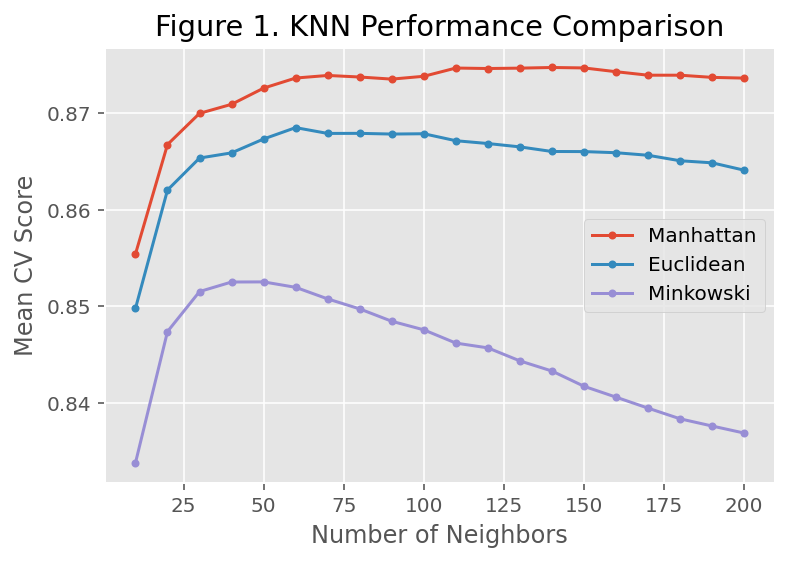

In [22]:
for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = results_KNN[results_KNN['metric'] == i]
    plt.plot(temp['n_neighbors'], temp['test_score'], marker = '.', label = i)
    
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel("Mean CV Score")
plt.title("Figure 1. KNN Performance Comparison")
plt.show()

The _k_-nearest neighbors algorithm seems to consistently prefer the Manhattan distances, with a strong preference towards more neighbors. The number of neighbors with the Manhattan distance tends to be between 110 to 150 neighbors. However, based on the `gs_kNN.best_params_`, the best value is k = `140` with the Manhattan distance. This results in a score of around `0.875`.

### <a id = 'DT1'>Decision Tree</a>

In [23]:
df_classifier = DecisionTreeClassifier(random_state = 999)

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
'max_depth': np.arange(1,21),
'min_samples_split': [5, 10, 15, 20, 25]}

gs_DT = GridSearchCV(estimator = df_classifier,
                     param_grid = params_DT,
                     cv = cv_method,
                     verbose = 1,
                     n_jobs = -1,
                     scoring = 'accuracy')

In [24]:
gs_DT.fit(D_train, t_train)

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=DecisionTreeClassifier(random_state=999), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'min_samples_split': [5, 10, 15, 20, 25]},
             scoring='accuracy', verbose=1)

In [25]:
gs_DT.best_params_

{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 25}

In [26]:
gs_DT.best_score_

0.7807811252992818

In [27]:
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']
results_DT['criterion'] = results_DT['criterion'].replace(['gini', 'entropy'], ['Gini', 'Entropy'])
results_DT.head()

,criterion,max_depth,min_samples_split,test_score
0,Gini,1,5,0.725323
1,Gini,1,10,0.725323
2,Gini,1,15,0.725323
3,Gini,1,20,0.725323
4,Gini,1,25,0.725323


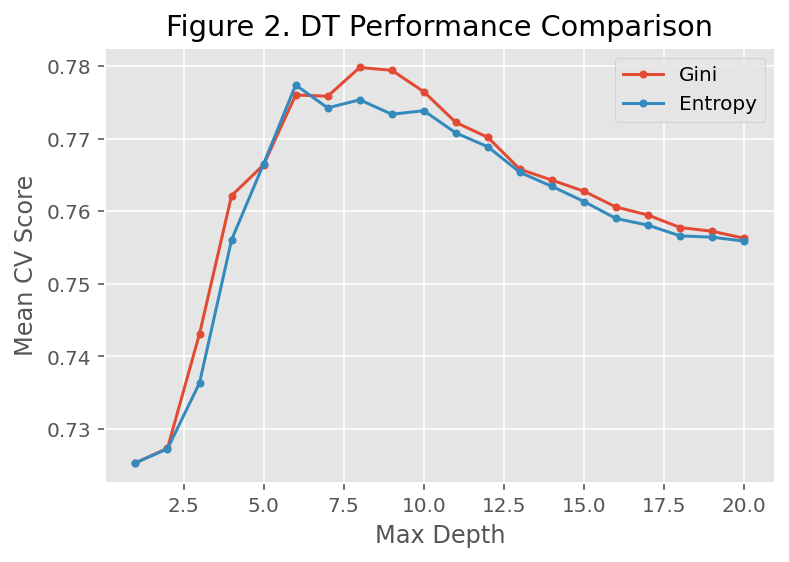

In [28]:
for i in ['Gini', 'Entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("Figure 2. DT Performance Comparison")
plt.show()

For the Decision Tree algorithm, the best way to tune the algorithm is to have a depth between `7` and `10` using the Gini Index. According to `gs_DT.best_params_`, the best depth value is at depth of `9` with the Gini Index and `25` as the minimum needed for a split. This model provides a cross validation score of approximately `0.781`.

### <a id ='RF1'>Random Forest</a>

In [29]:
params_RF = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [3, 6, 9, 12, 14, 17, 20, 23, 26, 29, 32]}

gs_RF = GridSearchCV(estimator = RandomForestClassifier(),
                     param_grid = params_RF,
                     cv = cv_method,
                     n_jobs = -1,
                     verbose = 1,
                     scoring = 'accuracy')

In [30]:
gs_RF.fit(D_train, t_train)

Fitting 15 folds for each of 55 candidates, totalling 825 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12, 14, 17, 20, 23, 26, 29, 32],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=1)

In [31]:
gs_RF.best_params_

{'max_depth': 26, 'n_estimators': 500}

In [32]:
gs_RF.best_score_

0.8248483639265761

In [33]:
results_RF = pd.DataFrame(gs_RF.cv_results_['params'])
results_RF['score'] = gs_RF.cv_results_['mean_test_score']
results_RF.head()

,max_depth,n_estimators,score
0,3,100,0.785172
1,3,200,0.786587
2,3,300,0.785321
3,3,400,0.785098
4,3,500,0.785544


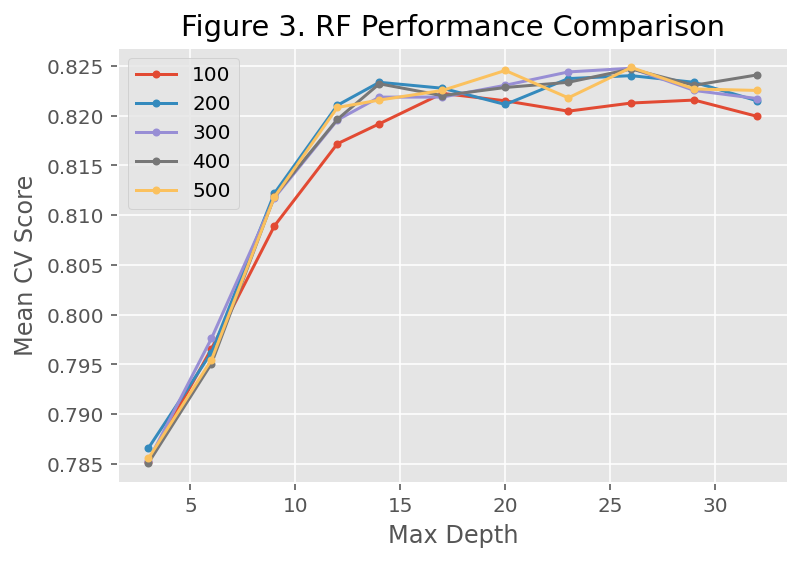

In [34]:
for i in [100, 200, 300, 400, 500]:
    temp = results_RF[results_RF['n_estimators'] == i]
    #temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp['max_depth'], temp['score'], marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("Figure 3. RF Performance Comparison")
plt.show()

The random forest algorithm seems to offer very mixed results, with different `n_estimators` offering the best models at different depths. Based on the plot, it appears evident that the algorithm prefers both more depth and estimators. However, with the current boundaries on the depth, the best parameters this model are with `500` estimators and and a maximum depth of `26`. This provides a cross validation score of approximately `0.825`.

### <a id = 'NB'>Naive Bayes</a>

In [35]:
from sklearn.preprocessing import PowerTransformer

np.random.seed(999)

nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

D_train_transformed = PowerTransformer().fit_transform(D_train)

gs_NB.fit(D_train_transformed, t_train);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [36]:
gs_NB.best_params_

{'var_smoothing': 0.03511191734215131}

In [37]:
gs_NB.best_score_

0.6723260009310987

In [38]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']
results_NB.head()

,var_smoothing,test_score
0,1.000000,0.607862
1,0.811131,0.614636
2,0.657933,0.622155
3,0.533670,0.630269
4,0.432876,0.637862


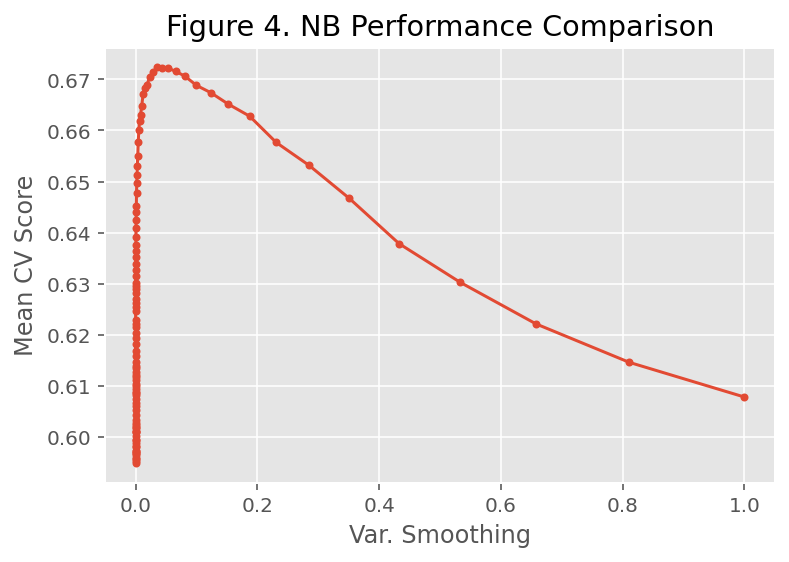

In [39]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("Figure 4. NB Performance Comparison")
plt.show()

The plot shows that for this dataset, the naive Bayes algorithm works best with less variance smoothing. According to `gs_NB.best_params_`, the best value for variance smoothing is approximately `0.035` with a score of `0.672`.

### <a id ='SV1'>Support-Vector Machine</a>

In [40]:
svm_classifier = SVC(probability = True)

params_SVM = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

# params_SVM = {'C': [0.1, 1, 10, 100, 1000],
#               'kernel': ['linear']}

gs_SVM = GridSearchCV(estimator = svm_classifier,
                      param_grid = params_SVM,
                      cv = cv_method,
                      verbose = 1,
                      n_jobs = -1,
                      scoring = 'accuracy')

In [41]:
gs_SVM.fit(D_train, t_train)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [42]:
gs_SVM.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [43]:
gs_SVM.best_score_

0.8128618814844373

In [44]:
results_SVM = pd.DataFrame(gs_SVM.cv_results_['params'])
results_SVM['score'] = gs_SVM.cv_results_['mean_test_score']
results_SVM.head()

,C,gamma,kernel,score
0,0.1,1.000,rbf,0.558433
1,0.1,0.100,rbf,0.796486
2,0.1,0.010,rbf,0.772147
3,0.1,0.001,rbf,0.631310
4,1.0,1.000,rbf,0.741104


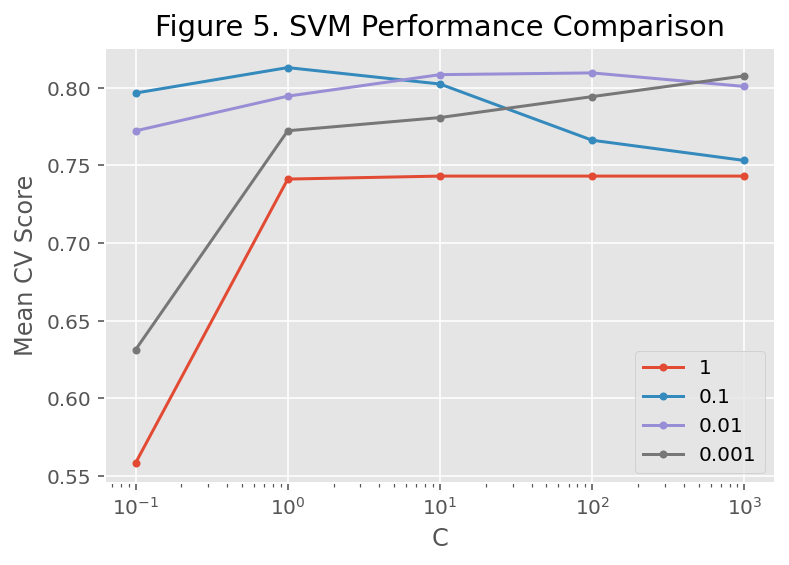

In [45]:
for i in [1, 0.1, 0.01, 0.001]:
    temp = results_SVM[results_SVM['gamma'] == i]
    plt.plot(temp['C'], temp['score'], marker = '.', label = i)
    
    
plt.legend()
plt.semilogx()
plt.xlabel('C')
plt.ylabel("Mean CV Score")
plt.title("Figure 5. SVM Performance Comparison")
plt.show()

The plot for support-vector machine (SVM) presents a similar problem to the random forests algorithm in that the plot provides mixed results through no single gamma value provides the best model at each C value. According to `gs_SVM.best_params_`, the best model for SVM is to have `gamma` = 0.1, `C` = 1, and to use the radius basis function (`rbf`) kernel. This SVM model for this dataset yields a score of `0.813`.

## <a id = 'MC'>Model Comparison and Evaluation</a>

### <a id = 'NN2'>K-Nearest Neighbors</a>

#### Model Accuracy

The _k_-nearest neighbors model had an overall accuracy of 77%, with a strength in its high recall. The model had precision of 0.71 and recall of 0.94 for predicting the positive cases from the feature. The high recall can be seen in the confusion matrix through 61 false negatives. The lower precision is from the 372 false positives of 1271 predictions of positive cases. These results mean that the model is far more reliable with its negative predictions that positive predictions, which could be a theoretical issue if positives need to be prioritised. Additionally, the accuracy could be improved by changing the probability needed for a case to be considered positive to greater than or equal to  0.6. 

In [46]:
t_pred = gs_KNN.predict(D_test)

In [47]:
metrics.accuracy_score(t_test, t_pred)

0.7744791666666667

In [48]:
metrics.confusion_matrix(t_test, t_pred)

array([[588, 372],
       [ 61, 899]], dtype=int64)

In [49]:
print(metrics.classification_report(t_test, t_pred))

              precision    recall  f1-score   support

           0       0.91      0.61      0.73       960
           1       0.71      0.94      0.81       960

    accuracy                           0.77      1920
   macro avg       0.81      0.77      0.77      1920
weighted avg       0.81      0.77      0.77      1920



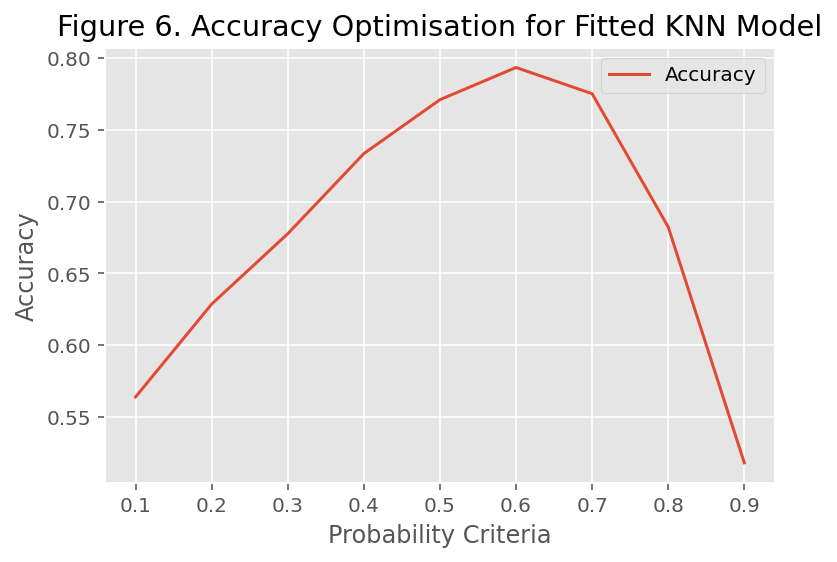

In [50]:
t_prob = gs_KNN.predict_proba(D_test)
criteria = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
accuracy = []
for i in criteria:
    accuracy.append(metrics.accuracy_score(t_test, t_prob[:, 1] >= i))
accuracyKNN = pd.DataFrame({'Criteria': criteria,
                        'Accuracy': accuracy})

accuracyKNN.plot.line('Criteria', 'Accuracy')
plt.xlabel('Probability Criteria')
plt.ylabel("Accuracy")
plt.title("Figure 6. Accuracy Optimisation for Fitted KNN Model")
plt.show()

#### ROC Curve

The ROC curve looks good but only reaches 0.8 and 0.2 for both the true positive and false positive rates respectively. Ideally, the curve reaches as close to the top left corner as possible, with being in the top left corner meaning it is a perfect model. The KNN model seems to have an even distribution of points with higher true positive rates than false positives. The ROC curve also shows that the model is able to maintain a steady amount of precision before seeing any significant amount of false positives.

In [51]:
t_prob_KNN = gs_KNN.predict_proba(D_test)
t_prob_KNN[0:10]

array([[0.37857143, 0.62142857],
       [0.17857143, 0.82142857],
       [0.23571429, 0.76428571],
       [0.42142857, 0.57857143],
       [0.17142857, 0.82857143],
       [0.35714286, 0.64285714],
       [0.93571429, 0.06428571],
       [0.23571429, 0.76428571],
       [0.17857143, 0.82142857],
       [0.45      , 0.55      ]])

In [52]:
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob_KNN[:, 1])
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8741438802083334

In [53]:
df_evaluation_KNN = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df_evaluation_KNN.head()

,fpr,tpr
0,0.000000,0.000000
1,0.000000,0.001042
2,0.000000,0.002083
3,0.000000,0.005208
4,0.001042,0.006250


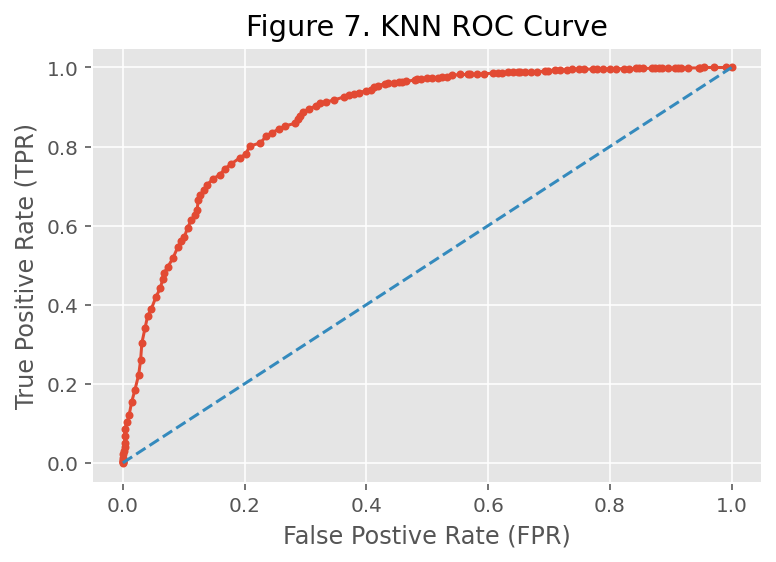

In [54]:
ax = df_evaluation_KNN.plot.line(x='fpr', y='tpr', title='Figure 7. KNN ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show()

### <a id = 'DT2'>Decision Tree</a>

#### Model Accuracy

The decision tree model had an overall accuracy of 79%, with a strength in recall. The model had precision of 0.77 and recall of 0.84 for predicting the positive cases from the feature. The distinction between these measures can be seen in the confusion matrix with a higher number of false positives than false negatives. Similar to the KNN model, this means the model is more reliable with its negative that positive predictions. The accuracy could be improved by changing the probability criteria to 0.7. 

In [55]:
t_pred = gs_DT.predict(D_test)

In [56]:
metrics.accuracy_score(t_test, t_pred)

0.7916666666666666

In [57]:
metrics.confusion_matrix(t_test, t_pred)

array([[713, 247],
       [153, 807]], dtype=int64)

In [58]:
print(metrics.classification_report(t_test, t_pred))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       960
           1       0.77      0.84      0.80       960

    accuracy                           0.79      1920
   macro avg       0.79      0.79      0.79      1920
weighted avg       0.79      0.79      0.79      1920



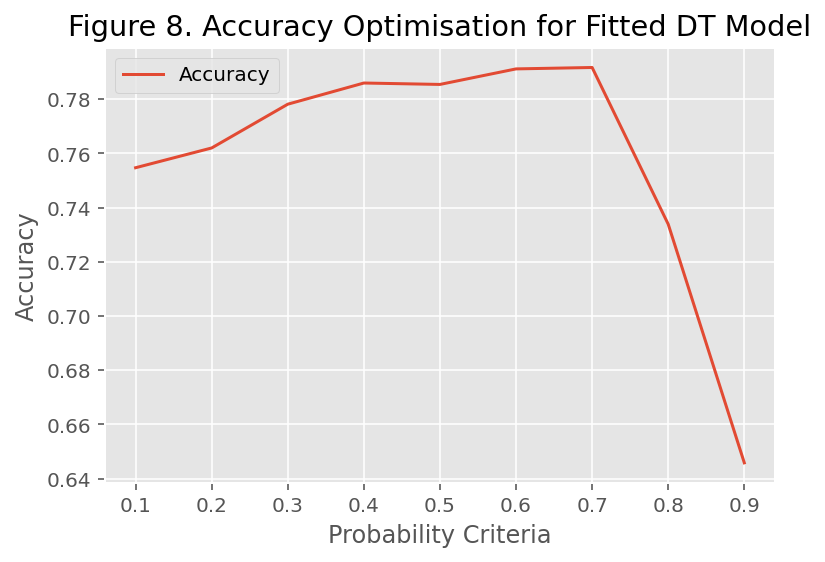

In [59]:
t_prob = gs_DT.predict_proba(D_test)
criteria = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
accuracy = []
for i in criteria:
    accuracy.append(metrics.accuracy_score(t_test, t_prob[:, 1] >= i))

accuracyDT = pd.DataFrame({'Criteria': criteria,
                        'Accuracy': accuracy})

accuracyDT.plot.line('Criteria', 'Accuracy')
plt.xlabel('Probability Criteria')
plt.ylabel("Accuracy")
plt.title("Figure 8. Accuracy Optimisation for Fitted DT Model")
plt.show()

#### ROC Curve

The ROC curve appears similar to the KNN model, although some details make it a bit better. The points for the true positive rate cluster highly around the 0.2 and the 0.4 false positive rate, showing that the model isn't as prone to error. The highest false error rate without letting the true positives reach maximum is just below 0.6.

In [60]:
t_prob_DT = gs_DT.predict_proba(D_test)
t_prob_DT[0:10]

array([[0.54545455, 0.45454545],
       [0.10793651, 0.89206349],
       [0.06929348, 0.93070652],
       [1.        , 0.        ],
       [0.06929348, 0.93070652],
       [0.28571429, 0.71428571],
       [0.77419355, 0.22580645],
       [0.54545455, 0.45454545],
       [0.10793651, 0.89206349],
       [0.25333333, 0.74666667]])

In [61]:
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob_DT[:, 1])
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8510590277777779

In [62]:
df_evaluation_DT = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df_evaluation_DT.head()

,fpr,tpr
0,0.000000,0.000000
1,0.005208,0.013542
2,0.009375,0.015625
3,0.020833,0.032292
4,0.053125,0.344792


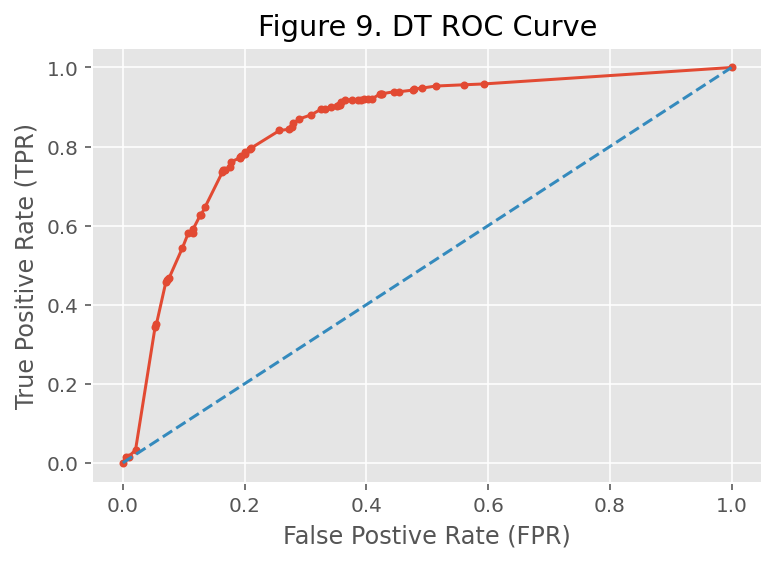

In [63]:
ax = df_evaluation_DT.plot.line(x='fpr', y='tpr', title='Figure 9. DT ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show();

### <a id = 'RF2'>Random Forest</a>

#### Model Accuracy

The random forest model had an overall accuracy of 83%, with similar scores for precision and recall. The model had precision of 0.81 and recall of 0.86 for predicting the positive cases from the feature. This can be seen in the confusion matrix through the similar number of false positives and false negatives. The highest accuracy is found with the standard 0.5 probability criteria. 

In [64]:
t_pred = gs_RF.predict(D_test)

In [65]:
metrics.accuracy_score(t_test, t_pred)

0.8302083333333333

In [66]:
metrics.confusion_matrix(t_test, t_pred)

array([[772, 188],
       [138, 822]], dtype=int64)

In [67]:
print(metrics.classification_report(t_test, t_pred))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83       960
           1       0.81      0.86      0.83       960

    accuracy                           0.83      1920
   macro avg       0.83      0.83      0.83      1920
weighted avg       0.83      0.83      0.83      1920



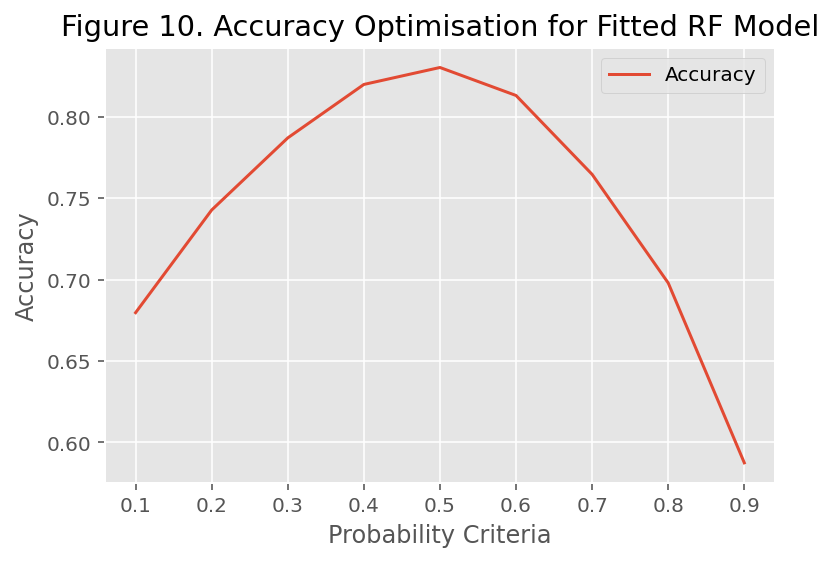

In [68]:
t_prob = gs_RF.predict_proba(D_test)
criteria = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
accuracy = []
for i in criteria:
    accuracy.append(metrics.accuracy_score(t_test, t_prob[:, 1] >= i))

accuracyRF = pd.DataFrame({'Criteria': criteria,
                        'Accuracy': accuracy})

accuracyRF.plot.line('Criteria', 'Accuracy')
plt.xlabel('Probability Criteria')
plt.ylabel("Accuracy")
plt.title("Figure 10. Accuracy Optimisation for Fitted RF Model")
plt.show()

#### ROC Curve

The ROC curve looks the best out of all the models, being the closest to the top left corner. This shows that the model can reach a high rate of true positives without coming across any false positive errors, as the curve shows that it was only at a true positive rate if about 0.85 did the false positive rate cross 0.2, unlike the ROC curves of the previous models where the 0.2 false positive rate was reached with lower true positive rates.

In [69]:
t_prob_RF = gs_RF.predict_proba(D_test)
t_prob_RF[0:10]

array([[0.3461589 , 0.6538411 ],
       [0.28518446, 0.71481554],
       [0.09902906, 0.90097094],
       [0.71733333, 0.28266667],
       [0.06765015, 0.93234985],
       [0.60592   , 0.39408   ],
       [0.948     , 0.052     ],
       [0.73663262, 0.26336738],
       [0.19917406, 0.80082594],
       [0.45660931, 0.54339069]])

In [70]:
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob_RF[:, 1])
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8987065972222222

In [71]:
df_evaluation_RF = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df_evaluation_RF.head()

,fpr,tpr
0,0.000000,0.000000
1,0.000000,0.001042
2,0.000000,0.003125
3,0.001042,0.003125
4,0.001042,0.011458


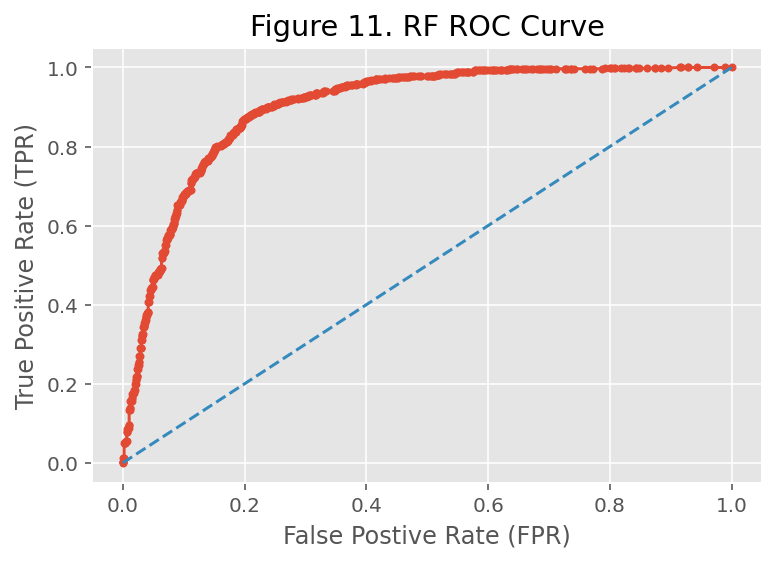

In [72]:
ax = df_evaluation_RF.plot.line(x='fpr', y='tpr', title='Figure 11. RF ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show()

### <a id = 'NB2'>Naive Bayes</a>

#### Model Accuracy

The naive Bayes model had with lowest overall accuracy with 66%. The model had precision of 0.6 and recall of 0.97 for predicting the positive feature. The very high recall with low precision means that the model caught almost all of the positive cases, although many false positives were found in the process. A byproduct of this is a high precision for the negative cases, meaning if something is predicted negative its likely to be negative. The confusion matrix demonstrates of 20 times the false positive count compared to the false negative count. For this model, the accuracy appears to increase to around 0.71 with a more conservative positive probability criteria of 0.9. 

In [73]:
t_pred = gs_NB.predict(D_test)

In [74]:
metrics.accuracy_score(t_test, t_pred)

0.6583333333333333

In [75]:
metrics.confusion_matrix(t_test, t_pred)

array([[337, 623],
       [ 33, 927]], dtype=int64)

In [76]:
print(metrics.classification_report(t_test, t_pred))

              precision    recall  f1-score   support

           0       0.91      0.35      0.51       960
           1       0.60      0.97      0.74       960

    accuracy                           0.66      1920
   macro avg       0.75      0.66      0.62      1920
weighted avg       0.75      0.66      0.62      1920



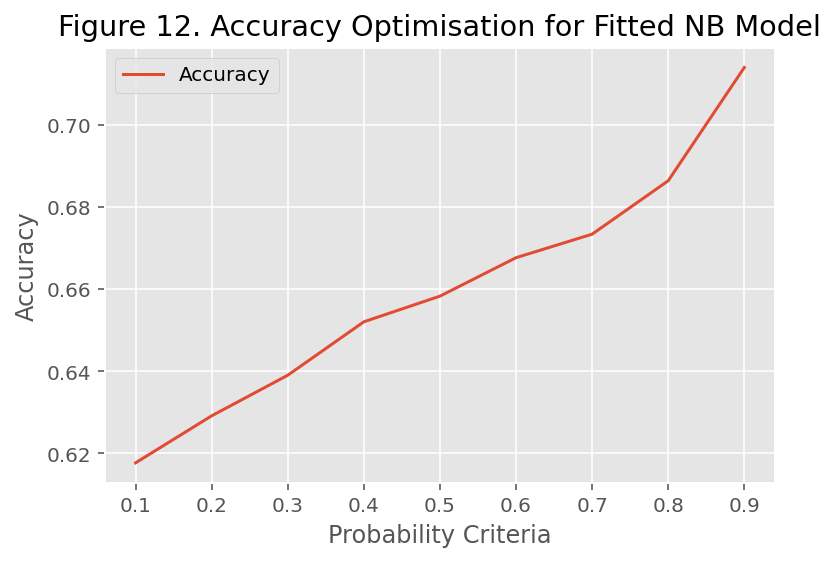

In [77]:
t_prob = gs_NB.predict_proba(D_test)
criteria = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
accuracy = []
for i in criteria:
    accuracy.append(metrics.accuracy_score(t_test, t_prob[:, 1] >= i))

accuracyNB = pd.DataFrame({'Criteria': criteria,
                        'Accuracy': accuracy})

accuracyNB.plot.line('Criteria', 'Accuracy')
plt.xlabel('Probability Criteria')
plt.ylabel("Accuracy")
plt.title("Figure 12. Accuracy Optimisation for Fitted NB Model")
plt.show()

#### ROC Curve

The ROC curve looks to be the most poor of all the models, being the furthest from the top left corner. Furthermore, the lower end of the ROC curve was prone to false positives, meaning that the model has a relatively high ratio of errors before any meaningful rate of true positives could be reached.

In [78]:
t_prob_NB = gs_NB.predict_proba(D_test)
t_prob_NB[0:10]

array([[2.51277951e-02, 9.74872205e-01],
       [6.91199153e-03, 9.93088008e-01],
       [5.12667594e-03, 9.94873324e-01],
       [1.47919763e-01, 8.52080237e-01],
       [3.77608831e-03, 9.96223912e-01],
       [1.11341501e-02, 9.88865850e-01],
       [9.99971347e-01, 2.86530615e-05],
       [7.33418554e-02, 9.26658145e-01],
       [4.15688654e-03, 9.95843113e-01],
       [2.83136875e-02, 9.71686313e-01]])

In [79]:
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob_NB[:, 1])
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8211924913194445

In [80]:
df_evaluation_NB = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df_evaluation_NB.head()

,fpr,tpr
0,0.000000,0.000000
1,0.001042,0.000000
2,0.001042,0.002083
3,0.002083,0.002083
4,0.002083,0.003125


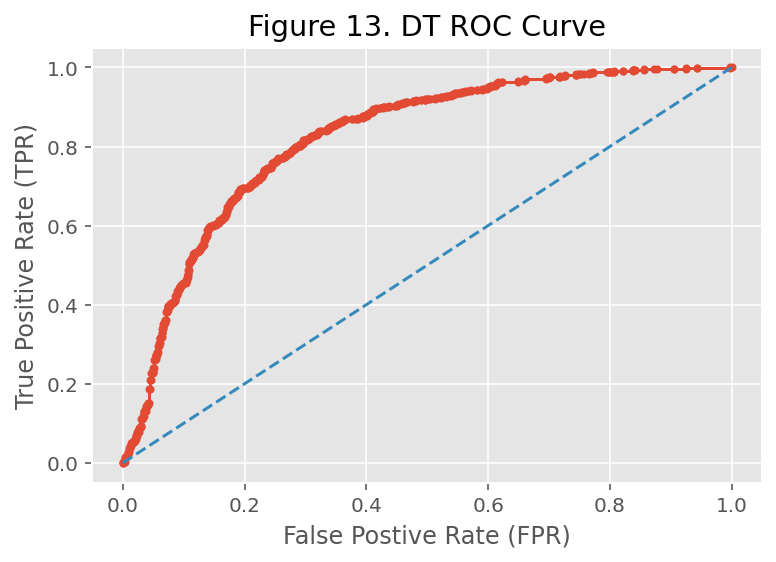

In [81]:
ax = df_evaluation_NB.plot.line(x='fpr', y='tpr', title='Figure 13. DT ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show()

### <a id = 'SV2'>Support-Vector Machine</a>

#### Model Accuracy

The support-vector machine model had an overall accuracy of 82%, with a higher recall score. The model had precision of 0.79 and recall of 0.87 for predicting the positive feature. Similar can be seen in the confusion matrix as the other models with higher recall scores. This model appears to be good at finding many positive cases without too many false positives. The highest accuracy is found with a probability criteria of 0.4. 

In [82]:
t_pred = gs_SVM.predict(D_test)

In [83]:
metrics.accuracy_score(t_test, t_pred)

0.8177083333333334

In [84]:
metrics.confusion_matrix(t_test, t_pred)

array([[734, 226],
       [124, 836]], dtype=int64)

In [85]:
print(metrics.classification_report(t_test, t_pred))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       960
           1       0.79      0.87      0.83       960

    accuracy                           0.82      1920
   macro avg       0.82      0.82      0.82      1920
weighted avg       0.82      0.82      0.82      1920



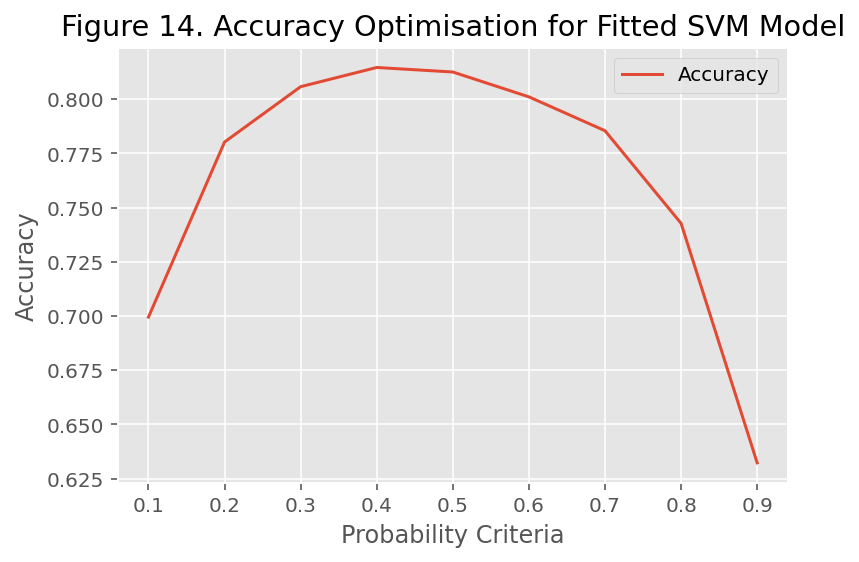

In [86]:
t_prob = gs_SVM.predict_proba(D_test)
criteria = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
accuracy = []
for i in criteria:
    accuracy.append(metrics.accuracy_score(t_test, t_prob[:, 1] >= i))

accuracySVM = pd.DataFrame({'Criteria': criteria,
                        'Accuracy': accuracy})

accuracySVM.plot.line('Criteria', 'Accuracy')
plt.xlabel('Probability Criteria')
plt.ylabel("Accuracy")
plt.title("Figure 14. Accuracy Optimisation for Fitted SVM Model")
plt.show()

#### ROC Curve

Finally, the ROC curve looks acceptable and perform similarly to the KNN and Decision Tree models. This shows that the model can reach a relatively high precision before seeing any significant amount of false positives, but for this dataset that precision isn't as high as the random forest model.

In [87]:
t_prob_SVM = gs_SVM.predict_proba(D_test)
t_prob_SVM[0:10]

array([[0.71275634, 0.28724366],
       [0.18952895, 0.81047105],
       [0.16310883, 0.83689117],
       [0.61226034, 0.38773966],
       [0.13929948, 0.86070052],
       [0.45140282, 0.54859718],
       [0.93535197, 0.06464803],
       [0.84701638, 0.15298362],
       [0.08423899, 0.91576101],
       [0.69406801, 0.30593199]])

In [88]:
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob_SVM[:, 1])
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8878423394097222

In [89]:
df_evaluation_SVM = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df_evaluation_SVM.head()

,fpr,tpr
0,0.000000,0.000000
1,0.000000,0.001042
2,0.000000,0.015625
3,0.001042,0.015625
4,0.001042,0.052083


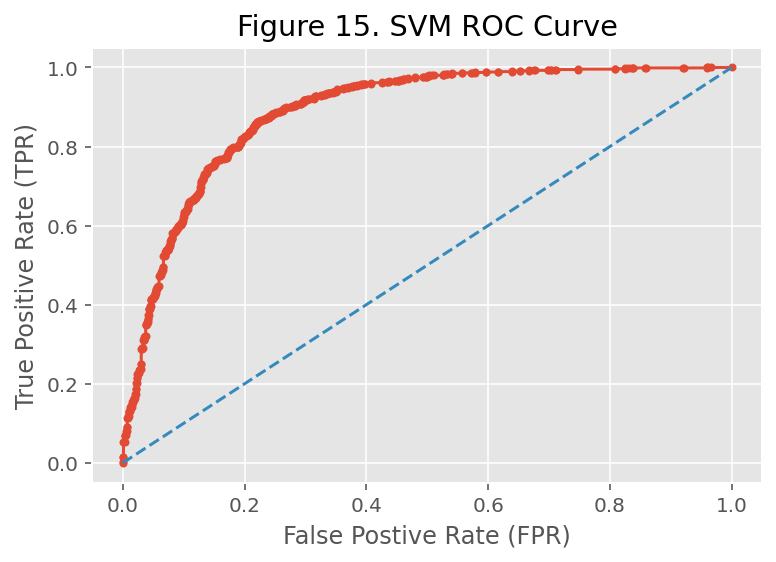

In [90]:
ax = df_evaluation_SVM.plot.line(x='fpr', y='tpr', title='Figure 15. SVM ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show()

### <a id = 'PC'>Performance Comparison</a>

The models were compared to investigate which would make the best predictions from the data. For this, cross validation scores were attained for each test. The results from this comparison demonstrated that the random forest algorithm would make the best model be fit the data. To confirm this, paired sample t-tests were used to compare the cross validation scores between the random forest model and the others. The results confirmed that the random forest model was a significantly more better model than the others, with p < .05 returned for all tests.

In [98]:
cv_method_ttest = RepeatedStratifiedKFold(n_splits=5, 
                                          n_repeats=5, 
                                          random_state=111)

cv_results_KNN = cross_val_score(estimator=gs_KNN.best_estimator_,
                                 X=Data,
                                 y=target, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')

cv_results_DT = cross_val_score(estimator=gs_DT.best_estimator_,
                                X=Data,
                                y=target, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')

cv_results_RF = cross_val_score(estimator=gs_RF.best_estimator_,
                                X=Data,
                                y=target, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')

cv_results_NB = cross_val_score(estimator=gs_NB.best_estimator_,
                                X=Data,
                                y=target, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')

cv_results_SVM = cross_val_score(estimator=gs_SVM.best_estimator_,
                                X=Data,
                                y=target, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')


cv_results_mean = [cv_results_KNN.mean().round(3), cv_results_DT.mean().round(3), cv_results_RF.mean().round(3), cv_results_NB.mean().round(3), cv_results_SVM.mean().round(3)]
df_cv_mean = pd.DataFrame({'Algorithms' : ['K-Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'SVM'],
                           'CV Results Means' : cv_results_mean})  
df_cv_mean

,Algorithms,CV Results Means
0,K-Nearest Neighbors,0.876
1,Decision Tree,0.846
2,Random Forest,0.901
3,Gaussian Naive Bayes,0.833
4,SVM,0.890


In [92]:
print(stats.ttest_rel(cv_results_RF, cv_results_KNN).pvalue.round(3))
print(stats.ttest_rel(cv_results_RF, cv_results_DT).pvalue.round(3))
print(stats.ttest_rel(cv_results_RF, cv_results_NB).pvalue.round(3))
print(stats.ttest_rel(cv_results_RF, cv_results_SVM).pvalue.round(3))

0.0
0.0
0.0
0.0


### <a id = 'BM'>Best Model</a>

The best model for predictions of which songs would be in the Billboard's Top 100 Weekly list was found to be the random forest algorithm. The model demonstrated an overall prediction accuracy of 83%, with a precison of 81% and recall of 86% for the songs in the test data. The high recall for songs in the top charting list means that a high number of songs that were actually in the top chart list were identified to be so by the algorithm. Additionally, the precison of 81% means that it did not have too many false positives when predicting the positive cases. As for the negative cases, the precison was 85%, meaning the algorithms predictions were more reliable for those than the positive cases. This demonstrates that the algorithm seems to have an easier time correctly predicting songs that were not in the chart toppers rather than those that were. 

It is also possible to alter the criteria for whether a case is positive or not. In this context, it would mean a higher likelihood of those that are predicted to be chart toppers to actually become a chart topper. In this, minimising false positives could be prioritised and false negatives given less priority. However, this would increase the number of songs that were not thought to be chart toppers, only to become wildly popular. A conservative criteria of 0.98 can be chosen and would result in a precison of 100%. However, as seen in the confusion matrix, a drastically more conservative criteria would only lead poor recall, with 2 songs being correctly guessed out of 960. In a business context, a profit matrix could be used to optimise how conservative a criteria is needed to maximise profits.

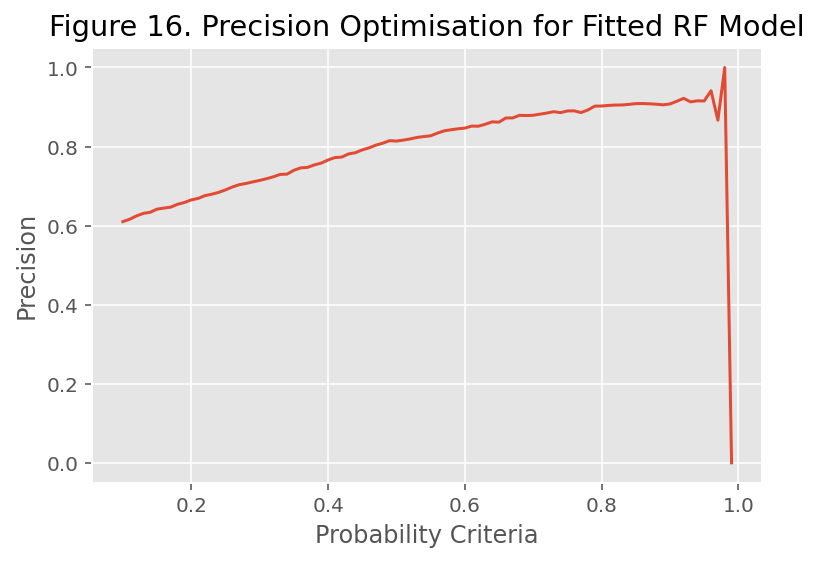

In [93]:
t_prob = gs_RF.predict_proba(D_test)
criteria = np.arange(.1, 1, .01)
precision = []
for i in criteria:
    precision.append(metrics.precision_score(t_test, t_prob[:, 1] >= i))
precisionRF = pd.DataFrame({'Criteria': criteria,
                        'Precision': precision})
precisionRF.head()
precisionRF.plot.line('Criteria', 'Precision', legend = None)
plt.xlabel('Probability Criteria')
plt.ylabel("Precision")
plt.title("Figure 16. Precision Optimisation for Fitted RF Model")
plt.show()

In [94]:
precisionRF.loc[precisionRF['Precision'] == precisionRF['Precision'].max()]

,Criteria,Precision
88,0.98,1.0


In [99]:
metrics.confusion_matrix(t_test, t_prob[:, 1] >= .98)

array([[960,   0],
       [958,   2]], dtype=int64)

In [100]:
print(metrics.classification_report(t_test, t_prob[:, 1] >= .98))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       960
           1       1.00      0.00      0.00       960

    accuracy                           0.50      1920
   macro avg       0.75      0.50      0.34      1920
weighted avg       0.75      0.50      0.34      1920



# <a id = 'CL'>Critique & Limitations</a>

Although the random forest model demonstrated good evaluation statistics, some limitations still need to be addressed. Primarily is the limitation of generalisability, and the constent challenge of finding a model which can make predictions with new data. Specifically, the model might have issues adopting a more general view 'hits' with the model currently trained to see 'hits' as Billboard does. Additionally, the model may struggle to generalise to other time frames (instead of just 2010 to 2019) and aren't exclusive to the Billboard Top series.  

The number of observations in the dataset may not be sufficient for a model such as random forest to be effective with completely new data. Since the random forest algorithm classifies the data through a more brute force method based on the data it is given, it is not as adaptive. This is opposite to a naive Bayes model for example, which through being probability based can make estimates for new data. More data may significantly improve random forest's generalisability with large variability in music.

A limitation of this model may be its generalisability. Since the models are based on the songs in the Billboard's Weekly Top 100 List from 2010 to 2019, the model may perform poorly with music that strays from the conventions found in this subset of music. One example of this would be that the music from 2020 to 2029 may be qualitatively different from the music in this dataset in a way that is not noticable by the algorithm through the given descriptive features. A more abstract example may be found from considering 'hit' songs from other countries in other languages. One example is the recent wave of South Korean Pop music (shortened to K-Pop) that is charting on the Billboard Top 100s within the past couple of years. Even though South Korea only recently became internationally renown, they have had their own popularity lists that also precipitated into the large craze they are today. Therefore, while the algorithms may perform well when predicting songs to be in Billboards list, it may not perform as well to classify international 'hits' from other countries despite this being its aim. Additional features may need to be added to predict popular songs from other languages or cultures.

An additional limitation is not able to account for changing trends. Since the model lacks a time component, it is not able to predict whether a certian descriptive feature is going to be more or less popular in the next year. This is useful considering the nature of music culture and how it changes over time. For example, instrumentalness could become more popular such that in 2011 its a larger influence on whether a song in in the top 100 list as compared to 2010. A contributing factor to the success of certain songs may have been the timing of the release, and how suited it was to the market at that point in time. However, this suitablility is not a descriptive feature in the model. Since the model treats the whole dataset as a static point in time, the model accuracy and ROC curves may be improved through the addition of time data. 

A possible solution to increase generalisability is to have the target feature better reflect music realistic proportions of successful songs. Since only set number of songs make it to the Billboard's list it is unrealistics for half of our observations to be in the list. Results from machine learning algorithms may be better if we had a higher number of songs that did not make the list. For example, 75% of the target feature could be songs that did not make the list with 25% being songs that made it. This would allow for the data to better reflect how music is consumed without having so few positives in the target feature for the algorithms not the be effective.

# <a id = 'SM'>Summary</a>

## <a id = 'PS'>Project Summary</a>

In Phase 1 of this project, we decided that the it would be better to use every observation of the dataset, drop one feature called `sections`, and give the dataset the necessary one-hot encodings and discretization. This was because of the nature of the dataset, where every observation is a song or podcast that is relatively unique. Removing any of these observations would dismiss potential trends, especially since the dataset uses songs that are more recent, which makes predicting future trends important. 

Because of our conclusions in Phase 1, we ran this large dataset through several methods of feature selections to help narrow it down. From here, it would be simple enough to run the dataset with stripped down features through five potential classification methods. However, we found that in this phase, the best model required every feature of the modified dataset. After tuning the parameters of the different methods to achieve their optimal scores through grid searches, out of all the optimal models, the most appropriate model would use a method of random forests with the parameters, `n_estimators` = `500`, and `max_depth` = `26`.

## <a id = 'SF'>Summary of Findings</a>

As previously stated, the best way to model the Spotify dataset in predicting whether or not a song will reach Billboard's Weekly Top 100 is through the use of a random forest algorithm with the parameters `n_estimators` = `500` and `max_depth` = `26`. This is best done on the given Spotify dataset with every feature except for `sections`, given that the data was one-hot encoded and given a robust scaling. 

The fact that the test results demonstrated strong results for the test data means that the model should preform well with new data and be sufficiently generalisable for practical use. However, it just means that almost every aspect of the song must be taken into account to reliably predict the next big 'hit' song (at least, according to Billboard). This can be time-consuming to not only process through the model, but also to record observations due to the subjectivity of scales in the the majority of the features.

# <a id = 'CO'>Conclusion</a>

In conclusion, it was possible to predict which songs would be in the Billboard's Weekly Top 100 List from 2010 to 2019 with the Spotify dataset. For this, a random forest algorithm was found to be the most successful, with 500 estimators and a max depth of 26. However, this model does have its problems, as it does not consider metrics outside of the Billboard's Top Hot 100 or the time frame of the dataset. Further study could be undertaken to utilise different metrics outside of Billboard's Hot lists, a differently defined set of features. A larger datasets that either include more songs from 2010 to 2019 or include songs from a larger time frame within Spotify's database, such as the years 2000 to 2019, could be effective training data. With this further study, a different model utilising other algorithms like naive Bayes or _k_-nearest neighbors might be more effective, and can provide better generalisability. However, Assuming music continues similarly in 2020 to 2029, this trained algorithm should allow for accurate and precise predictions of which songs will be successful. 

# <a id = 'REF'>References</a>

* Ansari, F. (2020). _The Spotify Hit Predictor Dataset (1960-2019)_ \[Dataset]. Kaggle. https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset/.